In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt


In [2]:
@njit
def polymergenerator(polymerl, headl):
    # Define the center-of-mass (COM) as a 2D vector.
    COM = np.array([5.0, 2.5])
    # Create a linear polymer (each row is a 2D coordinate)
    polymer = np.empty((polymerl, 2))
    for i in range(polymerl):
        polymer[i, 0] = float(i)
        polymer[i, 1] = 0.0
    # Create a polymer surface by shifting the polymer in x (e.g., by 0.2)
    polymersurface = np.empty((polymerl, 2))
    for i in range(polymerl):
        polymersurface[i, 0] = polymer[i, 0] + 0.2
        polymersurface[i, 1] = polymer[i, 1]
    # Create a head surface (with 4 atoms surrounding COM)
    headsurface = np.empty((4, 2))
    for i in range(4):
        headsurface[i, 0] = COM[0]
        headsurface[i, 1] = COM[1]
    # Add small offsets to the head positions
    offsets = np.array([[0.1, 0.0],
                        [0.0, 0.1],
                        [-0.1, 0.0],
                        [0.0, -0.1]])
    for i in range(4):
        headsurface[i, 0] += offsets[i, 0]
        headsurface[i, 1] += offsets[i, 1]
    return polymer, polymersurface, COM, headsurface

In [3]:

@njit
def lj_brownian(a, b, epsilon=0.1, sigma=2.0):
    """
    Computes a Lennard-Jones–type force between each point in array `a` and the single point `b` (2D).
    """
    N = a.shape[0]
    f_total0 = 0.0
    f_total1 = 0.0
    for i in range(N):
        dx = a[i, 0] - b[0]
        dy = a[i, 1] - b[1]
        dist = np.sqrt(dx * dx + dy * dy)
        if dist == 0:
            continue
        f_val = 24 * epsilon * (-2 * (sigma ** 12 / (dist ** 13)) + (sigma ** 6 / (dist ** 7)))
        inv_dist = 1.0 / dist
        f_total0 += f_val * dx * inv_dist
        f_total1 += f_val * dy * inv_dist
    res = np.empty(2)
    res[0] = f_total0
    res[1] = f_total1
    return res


@njit
def harmonic_angle_2d(surface, COM, n, theta=np.pi / 2, K=2.0):
    """
    Compute the harmonic–angle force for each atom in the surface in 2D.
    
    For each atom, we calculate the angle between the vector from COM to that atom and the
    vector from COM to its neighbor (with index rolled by n). The force is applied in the direction
    perpendicular to the vector from COM to the atom. The sign is determined by the (scalar) 2D cross product.
    """
    N = surface.shape[0]
    force = np.empty((N, 2))
    for i in range(N):
        # Vector from COM to atom i
        ax = surface[i, 0] - COM[0]
        ay = surface[i, 1] - COM[1]
        a_norm = np.sqrt(ax * ax + ay * ay)

        # Rolled index (i+n) modulo N
        j = (i + n) % N
        bx = surface[j, 0] - COM[0]
        by = surface[j, 1] - COM[1]
        b_norm = np.sqrt(bx * bx + by * by)

        # Compute cosine of the angle between the two vectors.
        if a_norm * b_norm == 0:
            cos_angle = 1.0
        else:
            cos_angle = (ax * bx + ay * by) / (a_norm * b_norm)
        if cos_angle > 1.0:
            cos_angle = 1.0
        elif cos_angle < -1.0:
            cos_angle = -1.0

        angle = np.arccos(cos_angle)
        angle_diff = theta - angle

        # Determine sign via the 2D cross product (scalar)
        cross = ax * by - ay * bx
        sign = 1.0
        if cross < 0:
            sign = -1.0

        # Compute the force direction: perpendicular to (ax,ay).
        if a_norm != 0:
            # A perpendicular vector to (ax,ay) in 2D is (-ay, ax).
            perp_x = -ay / a_norm
            perp_y = ax / a_norm
            # Multiply by sign so that the force tends to restore the target angle.
            perp_x = sign * perp_x
            perp_y = sign * perp_y
            force[i, 0] = -2 * K * angle_diff * perp_x
            force[i, 1] = -2 * K * angle_diff * perp_y
        else:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
    return force


@njit
def harmonic_surface(surface, COM, epsilon=1.0, sigma=0.1):
    """
    Compute a harmonic bond force for the surface atoms relative to COM in 2D.
    """
    N = surface.shape[0]
    force = np.empty((N, 2))
    for i in range(N):
        dx = surface[i, 0] - COM[0]
        dy = surface[i, 1] - COM[1]
        norm_val = np.sqrt(dx * dx + dy * dy)
        if norm_val == 0:
            force[i, 0] = 0.0
            force[i, 1] = 0.0
        else:
            factor = 2 * epsilon * (sigma - norm_val) / norm_val
            force[i, 0] = factor * dx
            force[i, 1] = factor * dy
    return force

In [21]:
@njit
def notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface):
    # Generate a random force vector for this time step (2D).
    random_forces = np.empty(2)
    for i in range(2):
        random_forces[i] = np.random.uniform(-random_val, random_val)

    # Compute the three harmonic angle forces (using our 2D version).
    force1 = harmonic_angle_2d(surface, COM, 1)
    force2 = harmonic_angle_2d(surface, COM, -1)
    force3 = harmonic_angle_2d(surface, COM, 2, np.pi)
    # Sum the forces for each atom in the surface.
    angle_forces = np.empty((surface.shape[0], 2))
    for i in range(surface.shape[0]):
        angle_forces[i, 0] = force1[i, 0] + force2[i, 0] + force3[i, 0]
        angle_forces[i, 1] = force1[i, 1] + force2[i, 1] + force3[i, 1]

    # Get the harmonic bond force.
    harmonic_bond = harmonic_surface(surface, COM)

    # Calculate the Lennard-Jones (Brownian) force on one particular surface atom.
    lj_force = lj_brownian(polymersurface, surface[3], 0.01, 0.4)

    # Compute the force on the COM from the polymer.
    lj_force_COM = lj_brownian(polymer, COM, 0.0001, 1.0)
    sum_hb0 = 0.0
    sum_hb1 = 0.0
    for i in range(harmonic_bond.shape[0]):
        sum_hb0 += harmonic_bond[i, 0]
        sum_hb1 += harmonic_bond[i, 1]

    # Update surface positions (for each of the 4 atoms).
    new_surface = np.empty_like(surface)
    for i in range(surface.shape[0]):
        new_surface[i, 0] = surface[i, 0] + dt * (
                    mu * (angle_forces[i, 0] + harmonic_bond[i, 0] + lj_force[0]) + np.random.uniform(-random_val,
                                                                                                      random_val))
        new_surface[i, 1] = surface[i, 1] + dt * (
                    mu * (angle_forces[i, 1] + harmonic_bond[i, 1] + lj_force[1]) + np.random.uniform(-random_val,
                                                                                                      random_val))

    # Update COM position.
    new_COM = np.empty(2)
    new_COM[0] = COM[0] + dt * (mu * lj_force_COM[0] - sum_hb0 + np.random.uniform(-random_val, random_val))
    new_COM[1] = COM[1] + dt * (mu * lj_force_COM[1] - sum_hb1 + np.random.uniform(-random_val, random_val))

    return new_COM, new_surface

In [22]:
@njit
def simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every):
    headhist = np.empty((steps, 2))
    surfacehist = np.empty((steps, surface.shape[0], 2))
    headhist[0] = COM
    surfacehist[0] = surface
    for i in range(1, steps):
        COM, surface = notverlet(COM, surface, dt, random_val, mu, polymer, polymersurface)
        headhist[i] = COM
        surfacehist[i] = surface
        if i % print_every == 0:
            print("Step", i, "/", steps, "COM:", COM[0], COM[1])
    return headhist, surfacehist


In [23]:

# Simulation parameters
polymerLength = 10  # number of polymer atoms
headN = 1
steps = 2000000
dt = 0.01
random_val = 0.3
mu = 1.0
print_every = 100000


polymer, polymersurface, COM, surface = polymergenerator(polymerLength, headN)
headhist, surfacehist = simulate(COM, surface, polymer, polymersurface, steps, dt, random_val, mu, print_every)
print("Simulation complete. Final COM:", headhist[steps - 1])

Step 100000 / 2000000 COM: 4.266790681860802 2.2054690928231975
Step 200000 / 2000000 COM: 3.8678551067941567 2.1249046008299524
Step 300000 / 2000000 COM: 3.984167730771268 1.5682076799228437
Step 400000 / 2000000 COM: 4.424760242274921 1.3365322580997792
Step 500000 / 2000000 COM: 3.673718229312278 0.9632928251588396
Step 600000 / 2000000 COM: 3.5583453709460007 0.8900041453468645
Step 700000 / 2000000 COM: 3.5129875881838797 0.8526826358372197
Step 800000 / 2000000 COM: 3.6682808247897274 0.9033995006105856
Step 900000 / 2000000 COM: 3.564936081470679 1.1815801604346219
Step 1000000 / 2000000 COM: 3.57892505156466 1.1171059429186867
Step 1100000 / 2000000 COM: 3.496826427524059 0.9080693347852159
Step 1200000 / 2000000 COM: 3.7001759474519695 1.1859644817969266
Step 1300000 / 2000000 COM: 2.833878310019597 1.0867568948174922
Step 1400000 / 2000000 COM: 2.6065278675778014 0.890055528160009
Step 1500000 / 2000000 COM: 2.501372592268631 0.8784767410502348
Step 1600000 / 2000000 COM: 2.

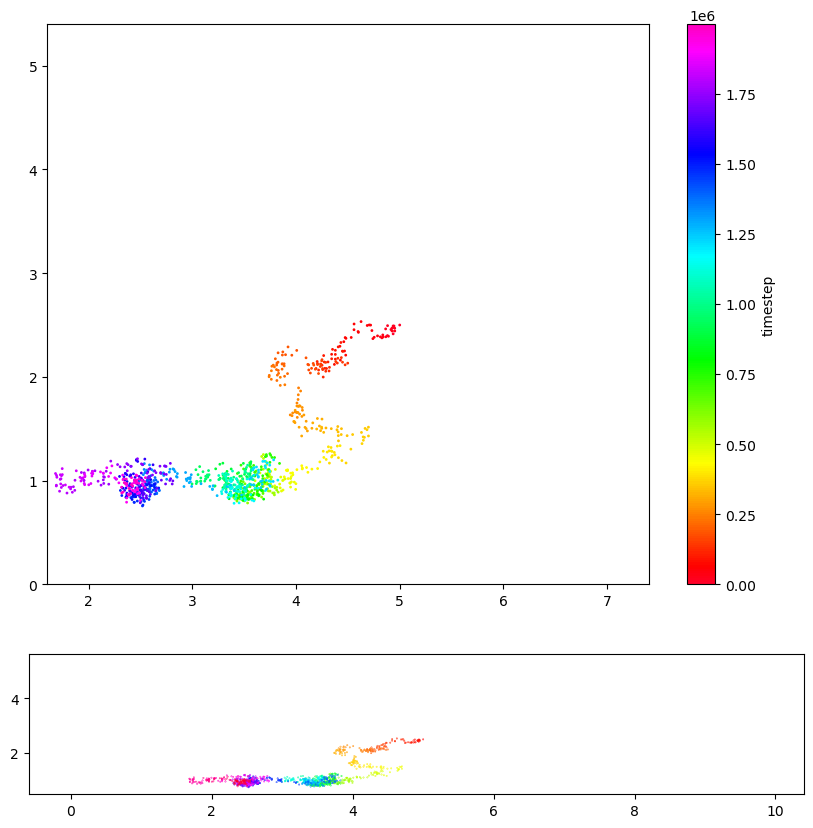

In [24]:
# Compute the orthogonal distance (now just the absolute y value, or norm of y if needed)
orthogonal_distance = np.abs(headhist[::2000, 1])
time_arr = np.arange(steps)

fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [4, 1]}, figsize=(10, 10))
pos = ax[0].scatter(headhist[::2000, 0], headhist[::2000, 1], cmap="gist_rainbow", c=time_arr[::2000], s=1)
ax[0].set_xlim(1.6, 7.4)
ax[0].set_ylim(0, 5.4)
ax[0].set_aspect("equal", adjustable="box")
perp = ax[1].scatter(headhist[::2000, 0], orthogonal_distance, cmap="hsv", c=time_arr[::2000], s=0.1)
ax[1].set_xlim(-0.6, 10.4)
ax[1].set_ylim(0.5, 5.6)
fig.colorbar(pos, label='timestep')
plt.show()

In [ ]:
with open("trajectory.xyz", "w") as f:
    step_interval = 1000
    num_frames = steps // step_interval
    for t in range(num_frames):
        # Combine COM and surface positions for the frame.
        positions = np.empty((surface.shape[0] + 1, 2))
        positions[0] = headhist[t * step_interval]
        for j in range(surface.shape[0]):
            positions[j + 1] = surfacehist[t * step_interval, j]
        f.write(f"{positions.shape[0]}\n\n")
        for i in range(positions.shape[0]):
            f.write(f"C{i + 1} {positions[i, 0]:8.3f} {positions[i, 1]:8.3f}\n")